In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import dandelion as ddl
sc.logging.print_header()

warnings.filterwarnings('ignore')
os.chdir('/lustre/scratch117/cellgen/team297/kt16/Ziad/scanpy')

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.4 scipy==1.5.2 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.1 python-igraph==0.8.3 leidenalg==0.8.2


In [2]:
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
anndata2ri.activate()
%load_ext rpy2.ipython

In [3]:
adata = sc.read_h5ad('h5ad/adata_soupx_trans_cite_rna.h5ad')
adata1 = sc.read_h5ad('h5ad/adata_soupx_trans_cite_raw.h5ad')
adata2 = sc.read_h5ad('h5ad/adata_soupx_trans_raw.h5ad')
adata3 = sc.read_h5ad('h5ad/adata_soupx_trans_cite_bgshift_raw.h5ad')

In [4]:
rna = sc.read_h5ad('h5ad/TNK_rna.h5ad')

In [5]:
# clean up each major celltype
rnax = rna[rna.obs['fine_clustering'].isin(['Vd2_gdT', 'Vd1_gdT'])].raw.to_adata().copy()
# Identify highly-variable genes
sc.pp.highly_variable_genes(rnax, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)
# stash the normalized data in raw
rnax.raw = rnax
# filter to only highly variable
rnax = rnax[:, rnax.var['highly_variable']]

In [6]:
sc.external.pp.harmony_integrate(rnax, key='study_id')
sc.pp.neighbors(rnax, use_rep = 'X_pca_harmony')

2021-03-11 10:06:04,300 - harmonypy - INFO - Iteration 1 of 10
2021-03-11 10:06:09,874 - harmonypy - INFO - Iteration 2 of 10
2021-03-11 10:06:14,877 - harmonypy - INFO - Iteration 3 of 10
2021-03-11 10:06:20,795 - harmonypy - INFO - Iteration 4 of 10
2021-03-11 10:06:25,471 - harmonypy - INFO - Iteration 5 of 10
2021-03-11 10:06:28,470 - harmonypy - INFO - Iteration 6 of 10
2021-03-11 10:06:32,889 - harmonypy - INFO - Iteration 7 of 10
2021-03-11 10:06:36,895 - harmonypy - INFO - Iteration 8 of 10
2021-03-11 10:06:38,897 - harmonypy - INFO - Iteration 9 of 10
2021-03-11 10:06:42,189 - harmonypy - INFO - Converged after 9 iterations


In [7]:
# run UMAP
sc.tl.umap(rnax, min_dist = 0.3)

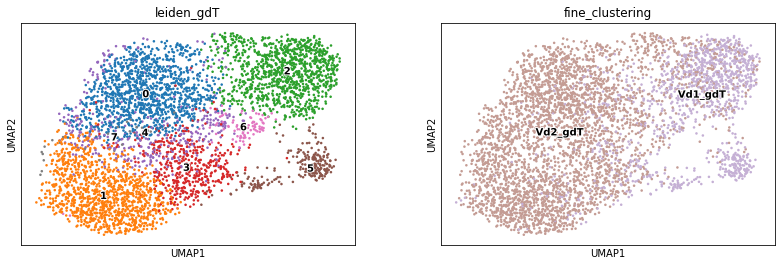

In [8]:
# find clusters
sc.tl.leiden(rnax, key_added = 'leiden_gdT')
# quick marker gene test
sc.pl.umap(rnax, color=['leiden_gdT', 'fine_clustering'], legend_loc ='on data', legend_fontoutline=2)

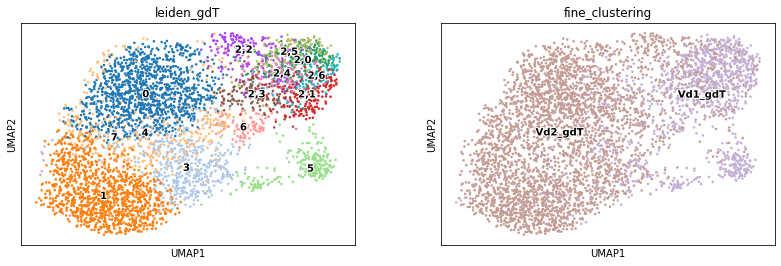

In [9]:
sc.tl.leiden(rnax, key_added = 'leiden_gdT',restrict_to = ['leiden_gdT', ['2']], resolution = .8)
# quick marker gene test
sc.pl.umap(rnax, color=['leiden_gdT', 'fine_clustering'], legend_loc ='on data', legend_fontoutline=2)

In [10]:
gdT = rna[rna.obs['fine_clustering'].isin(['Vd2_gdT', 'Vd1_gdT'])].raw.to_adata().copy()
gdT.obs['fine_clustering'] = gdT.obs['fine_clustering'].astype('object')
gdT.obs['fine_clustering'].update(rnax.obs['leiden_gdT'].astype('object'))

... storing 'fine_clustering' as categorical


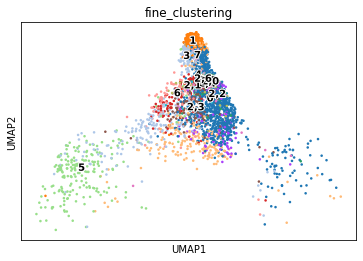

In [11]:
sc.pl.umap(gdT, color=['fine_clustering'], legend_loc ='on data', legend_fontoutline=2)

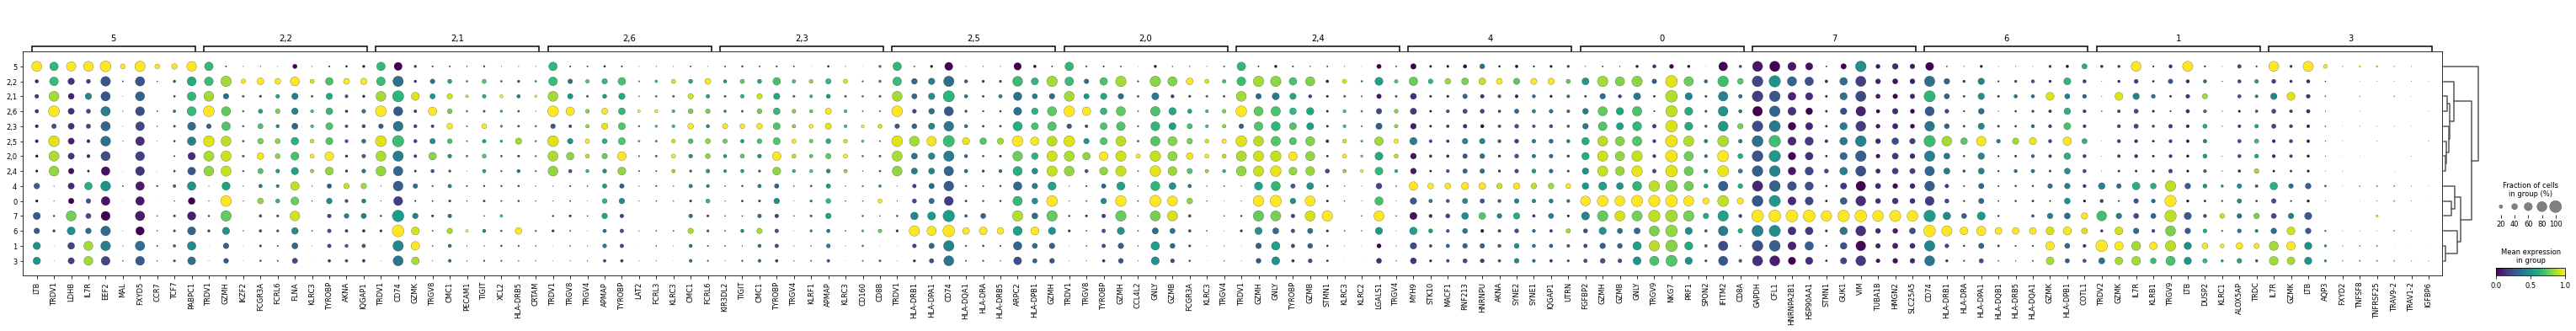

In [12]:
sc.tl.rank_genes_groups(rnax, groupby = 'leiden_gdT')
sc.tl.dendrogram(rnax, groupby = 'leiden_gdT')
sc.pl.rank_genes_groups_dotplot(rnax, n_genes = 10, standard_scale = 'var', color_map = 'viridis', min_logfoldchange=1)

... storing 'initial_clustering' as categorical
... storing 'fine_clustering' as categorical


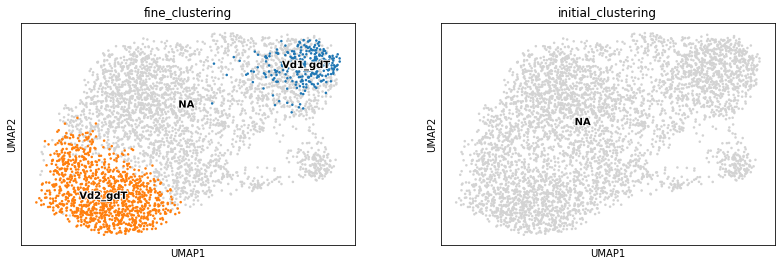

In [17]:
new_dict={'0':'doublets',
'1':'Vd2_gdT',
'2,0':'Vd1_gdT',
'2,1':'doublets',
'2,2':'doublets',
'2,3':'doublets',
'2,4':'doublets',
'2,5':'doublets',
'2,6':'Vd1_gdT',
'3':'doublets',
'4':'doublets',
'5':'doublets',
'6':'doublets',
'7':'doublets'}
new_dict2={'0':'doublets',
'1':'gdT',
'2,0':'gdT',
'2,1':'doublets',
'2,2':'doublets',
'2,3':'doublets',
'2,4':'doublets',
'2,5':'doublets',
'2,6':'gdT',
'3':'doublets',
'4':'doublets',
'5':'doublets',
'6':'doublets',
'7':'doublets'}
rnax.obs['fine_clustering'] = [new_dict[x] for x in rnax.obs['leiden_gdT']]
rnax.obs['initial_clustering'] = [new_dict2[x] for x in rnax.obs['leiden_gdT']]
sc.pl.umap(rnax, color=['fine_clustering', 'initial_clustering'], legend_loc ='on data', legend_fontoutline=2, groups = ['Vd2_gdT', 'Vd1_gdT'])

In [24]:
adata.obs['initial_clustering'] = adata.obs['initial_clustering'].astype('object')
adata.obs['fine_clustering'] = adata.obs['fine_clustering'].astype('object')
adata.obs['initial_clustering'].update(rnax.obs['initial_clustering'].astype('object'))
adata.obs['fine_clustering'].update(rnax.obs['fine_clustering'].astype('object'))

In [25]:
adata1.obs = adata.obs.copy()
adata2.obs = adata.obs.copy()
adata3.obs = adata.obs.copy()

In [26]:
# save temporarily
adata.write('h5ad/adata_soupx_trans_cite_rna.h5ad', compression = 'gzip')
adata1.write('h5ad/adata_soupx_trans_cite_raw.h5ad', compression = 'gzip')
adata2.write('h5ad/adata_soupx_trans_raw.h5ad', compression = 'gzip')
adata3.write('h5ad/adata_soupx_trans_cite_bgshift_raw.h5ad', compression = 'gzip')

... storing 'initial_clustering' as categorical
... storing 'fine_clustering' as categorical
... storing 'initial_clustering' as categorical
... storing 'fine_clustering' as categorical
... storing 'initial_clustering' as categorical
... storing 'fine_clustering' as categorical


In [14]:
list(set(rna.obs['fine_clustering']))

['CD16pos_NK',
 'CD4_Tcm',
 'Vd2_gdT',
 'CD16pos_SIGLEC7_NK',
 'CD4_CD25_IL17RB_T/NKT',
 'CD8_Tem',
 'CD4_Tem',
 'CD4_Tnaive',
 'Vd1_gdT',
 'CD16neg_NK',
 'MAIT',
 'CD4_Treg',
 'CD8_Temra',
 'CD8_Tnaive',
 'NKT']

In [58]:
# clean up each major celltype
rnax = rna[rna.obs['fine_clustering'].isin(['NKT', 'CD16pos_NK', 'CD16neg_NK', 'CD16pos_SIGLEC7_NK', 'CD4_CD25_IL17RB_T/NKT'])].raw.to_adata().copy()
# Identify highly-variable genes
sc.pp.highly_variable_genes(rnax, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)
# stash the normalized data in raw
rnax.raw = rnax
# filter to only highly variable
rnax = rnax[:, rnax.var['highly_variable']]

In [59]:
import multiprocessing
# regress and scale for PCA
sc.pp.regress_out(rnax, ['total_counts', 'pct_counts_mt'], n_jobs = multiprocessing.cpu_count()-1)
sc.pp.scale(rnax, max_value = 10)
sc.tl.pca(rnax, svd_solver = 'arpack')

In [60]:
sc.external.pp.harmony_integrate(rnax, key='study_id')
sc.pp.neighbors(rnax, use_rep = 'X_pca_harmony')

2021-03-10 16:19:33,217 - harmonypy - INFO - Iteration 1 of 10
2021-03-10 16:20:01,207 - harmonypy - INFO - Iteration 2 of 10
2021-03-10 16:20:29,592 - harmonypy - INFO - Converged after 2 iterations


In [61]:
# run UMAP
sc.tl.umap(rnax, min_dist = 0.3)

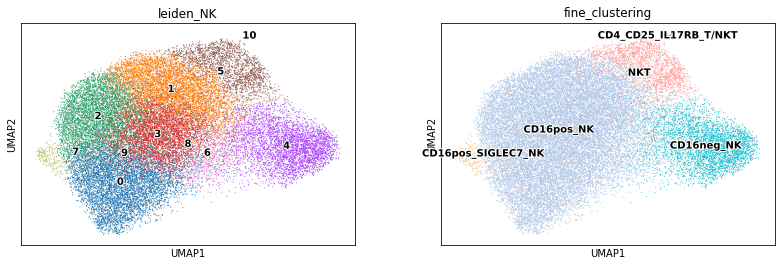

In [62]:
# find clusters
sc.tl.leiden(rnax, key_added = 'leiden_NK')
# quick marker gene test
sc.pl.umap(rnax, color=['leiden_NK', 'fine_clustering'], legend_loc ='on data', legend_fontoutline=2)

In [63]:
nks = rna[rna.obs['fine_clustering'].isin(['NKT', 'CD16pos_NK', 'CD16neg_NK', 'CD16pos_SIGLEC7_NK', 'CD4_CD25_IL17RB_T/NKT'])].raw.to_adata().copy()
nks.obs['fine_clustering'] = nks.obs['fine_clustering'].astype('object')
nks.obs['fine_clustering'].update(rnax.obs['leiden_NK'].astype('object'))

... storing 'fine_clustering' as categorical


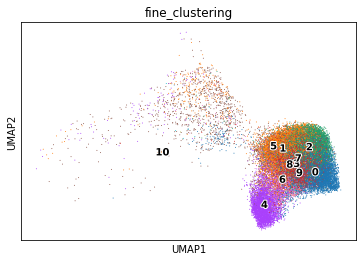

In [64]:
sc.pl.umap(nks, color=['fine_clustering'], legend_loc ='on data', legend_fontoutline=2)

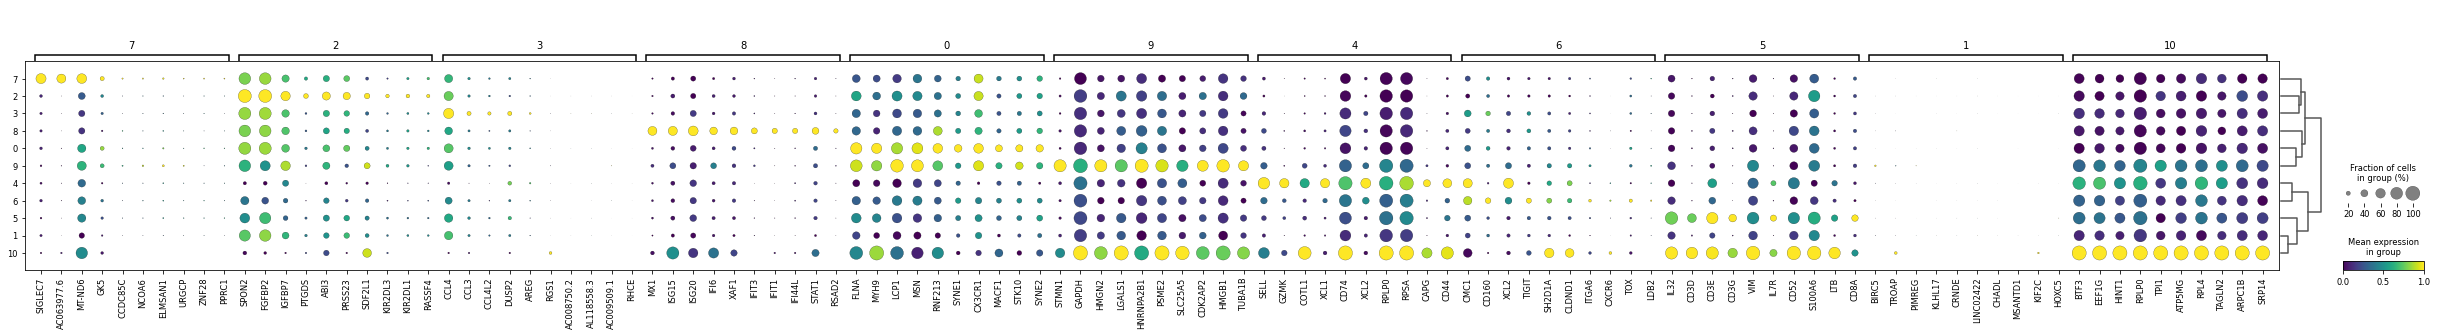

In [65]:
sc.tl.rank_genes_groups(rnax, groupby = 'leiden_NK')
sc.tl.dendrogram(rnax, groupby = 'leiden_NK')
sc.pl.rank_genes_groups_dotplot(rnax, n_genes = 10, standard_scale = 'var', color_map = 'viridis', min_logfoldchange=1)

In [73]:
rnax2 = rnax.copy()
rnax2.obsp = None
rnax2.uns.pop('neighbors')
rnax2 = rnax2.raw.to_adata()
rnax2

AnnData object with n_obs × n_vars = 31534 × 21233
    obs: 'sampleid', 'sampleid_study', 'timepoint', 'treatment', 'study_id', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'is_doublet', 'filter_rna', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'initial_clustering', 'fine_clustering', 'treatment_timepoint', 'sex', 'age', 'peak_trop', 'BNP', 'on_treatment_CRP', 'AEs', 'treatment_group_1', 'treatment_group_2', 'Lymph', 'CD4', 'CD8', 'Treg', 'leiden_NK'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'fine_clustering_colors', 'hvg', 'leiden', 'leiden_colors', 'pca', 'study_id_colors', 'treatment_colors', 'treatment_timepoint_colors', 'umap', 'leiden_NK_colors', 'rank_genes_groups', 'dendrogram_leiden_NK'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'

In [74]:
%%R -i rnax2
saveRDS(rnax2, 'h5ad/R/tmp_for_singler.RDS')

In [75]:
rnax2.write('h5ad/tmp.h5ad', compression = 'gzip')

### using SingleR for automated annotation
```R
setwd('/lustre/scratch117/cellgen/team297/kt16/Ziad/scanpy')
library(SingleR)
sce <- readRDS('h5ad/R/tmp_for_singler.RDS')
sce
# Loading required package: SingleCellExperiment
# class: SingleCellExperiment 
# dim: 1932 31534 
# metadata(12): fine_clustering_colors hvg ... rank_genes_groups
#   dendrogram_leiden_NK
# assays(1): X
# rownames(1932): HES4 ISG15 ... MT-ND6 AC240274.1
# rowData names(14): gene_ids feature_types ... mean std
# colnames(31534): Sample_Fq1_AAACCTGAGCCCAATT
#   Sample_Fq1_AAACCTGCAAGCCTAT ... Sample_Fq32_TTTGTCAGTTACAGAA
#   Sample_Fq32_TTTGTCATCTTTAGGG
# colData names(33): sampleid sampleid_study ... Treg leiden_NK
logcounts(sce) <- assays(sce)[['X']]
library(BiocParallel)

ref <- NovershternHematopoieticData()
pred1 <- SingleR(test=sce, ref=ref, labels=ref$label.fine, clusters = sce$leiden_NK, de.method="wilcox", BPPARAM = MulticoreParam())
write.csv(pred1, 'h5ad/R/tmp_for_singler_Novershtern_results.csv')

ref <- MonacoImmuneData()
pred2 <- SingleR(test=sce, ref=ref, labels=ref$label.fine, clusters = sce$leiden_NK, de.method="wilcox", BPPARAM = MulticoreParam())
write.csv(pred2, 'h5ad/R/tmp_for_singler_Monaco_results.csv')
```

In [76]:
res1 = pd.read_csv('h5ad/R/NKT_for_singler_Novershtern_results.csv', index_col = 0)
res2 = pd.read_csv('h5ad/R/NKT_for_singler_Monaco_results.csv', index_col = 0)
res1dict, res2dict = {}, {}
for a,b in zip(res1['pruned.labels'].index, res1['pruned.labels']):
    res1dict.update({str(a):b})
for a,b in zip(res2['pruned.labels'].index, res2['pruned.labels']):
    res2dict.update({str(a):b})

In [77]:
rnax.obs['Novershtern'] = [res1dict[x] for x in rnax.obs['leiden_NK']]
rnax.obs['Monaco'] = [res2dict[x] for x in rnax.obs['leiden_NK']]

... storing 'Novershtern' as categorical
... storing 'Monaco' as categorical


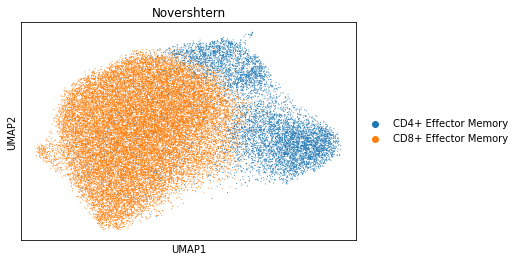

In [78]:
sc.pl.umap(rnax, color = 'Novershtern')

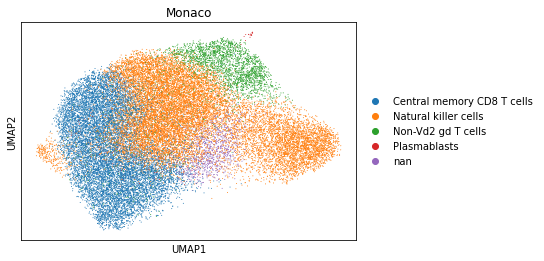

In [79]:
sc.pl.umap(rnax, color = 'Monaco')

:(

## Trying celltypist

```bash
# conda activate dandelion
# pip install celltypist-dev
celltypist --update-models
cd /lustre/scratch117/cellgen/team297/kt16/Ziad/scanpy
mkdir celltypist
celltypist --indata h5ad/tmp_NKT.h5ad --model Immune_All_Low.pkl --outdir celltypist --majority-voting
```

In [100]:
labels = pd.read_csv('celltypist/predicted_labels.csv', index_col = 0)
# probs = pd.read_csv('celltypist/probability_matrix.csv', index_col = 0)

In [101]:
rnax.obs['celltypist'] = labels['predicted labels after majority voting']

... storing 'celltypist' as categorical


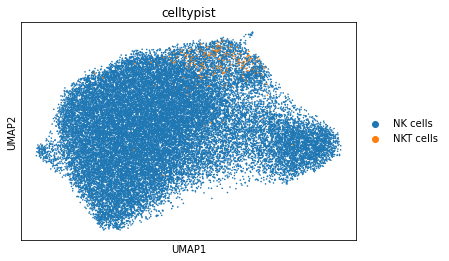

In [102]:
sc.pl.umap(rnax, color = 'celltypist', size = 10)

In [109]:
## pretty good
# let's try and do it for the T cells

In [124]:
# clean up each major celltype
rnax = rna[rna.obs['fine_clustering'].isin(['CD4_Tcm',
 'CD4_CD25_IL17RB_T/NKT',
 'CD8_Tem',
 'CD4_Tem',
 'CD4_Tnaive',
 'MAIT',
 'CD4_Treg',
 'CD8_Temra',
 'CD8_Tnaive'])].raw.to_adata().copy()
# Identify highly-variable genes
sc.pp.highly_variable_genes(rnax, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)
# stash the normalized data in raw
rnax.raw = rnax
# filter to only highly variable
rnax = rnax[:, rnax.var['highly_variable']]

In [125]:
import multiprocessing
# regress and scale for PCA
sc.pp.regress_out(rnax, ['total_counts', 'pct_counts_mt'], n_jobs = multiprocessing.cpu_count()-1)
sc.pp.scale(rnax, max_value = 10)
sc.tl.pca(rnax, svd_solver = 'arpack')

In [126]:
sc.external.pp.harmony_integrate(rnax, key='study_id')
sc.pp.neighbors(rnax, use_rep = 'X_pca_harmony')

2021-03-10 17:35:54,567 - harmonypy - INFO - Iteration 1 of 10
2021-03-10 17:37:22,769 - harmonypy - INFO - Iteration 2 of 10
2021-03-10 17:38:50,274 - harmonypy - INFO - Converged after 2 iterations


In [127]:
# run UMAP
sc.tl.umap(rnax, min_dist = 0.3)

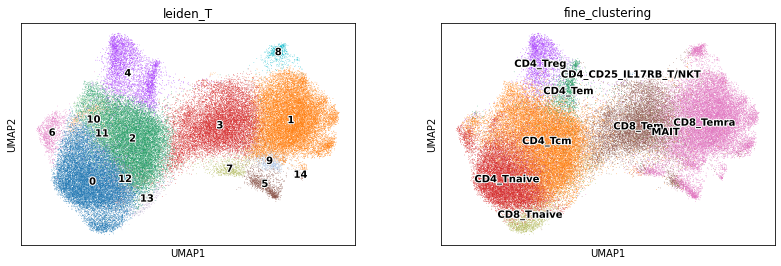

In [128]:
# find clusters
sc.tl.leiden(rnax, key_added = 'leiden_T')
# quick marker gene test
sc.pl.umap(rnax, color=['leiden_T', 'fine_clustering'], legend_loc ='on data', legend_fontoutline=2)

In [129]:
# save for celltypist
rnax = rnax.raw.to_adata()
rnax.write('h5ad/tmp.h5ad', compression = 'gzip')

... storing 'celltypist' as categorical


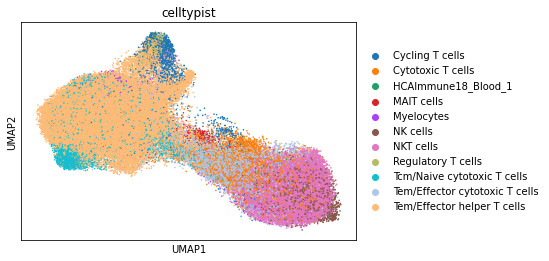

In [118]:
labels = pd.read_csv('celltypist/predicted_labels.csv', index_col = 0)
rnax.obs['celltypist'] = labels['predicted labels after majority voting']
sc.pl.umap(rnax, color = 'celltypist', size = 10)

In [121]:
# also for gdT?
gdT.write('h5ad/tmp.h5ad', compression = 'gzip')

... storing 'celltypist' as categorical


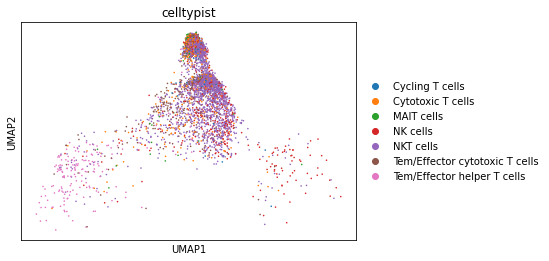

In [123]:
labels = pd.read_csv('celltypist/predicted_labels.csv', index_col = 0)
gdT.obs['celltypist'] = labels['predicted labels after majority voting']
sc.pl.umap(gdT, color = 'celltypist', size = 10)